# Filtro de partículas


Cada partícula vai ser representada por uma lista [x,y,theta]

Trabalhe com 2 listas:

	S = []  # Vai conter as n partículas. 

	W = [] # Pesos das partículas

	n_part = # Número de partículas


# Atividades


1. Crie uma função que gere n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy (passados como parâmetros). Veja a funcao 

	Devolve uma lista com n partículas

2. Descubra como desenhar as n partículas (analise o módulo inspercles)

3. Faça o desenho das partículas

4. Crie uma lista para simular os movimentos do robô. Veja a lista chamada <code>movimentos</code> que é usada na seção *Teste de animação*, mais abaixo

5. Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

6. Desenhe as partículas após o deslocamento

7. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Ou seja, para cada raio estimado $\hat{z_j}$ e leitura real $z_j$ calcule a probabilidade daquele raio ter acontecido dado que a posição do robô fosse de fato a da partícula


8 . Usando os resultados de 7 calcule $P(H|D)$ e insira numa lista de probabilidades das partículas

9 . Reamostre as partículas de forma proporcional à probabilidade



In [42]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff

import cv2

import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())

import fun
reload(fun)

import inspercles
reload(inspercles)





# Para suprimir alguns warnings do Matplotlib Inline
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


In [43]:
n_part = 40
minx = 50
miny = 50
maxy = 350
maxx = 350


## Diretõrio de trabalho

In [44]:
!pwd




/home/borg/catkin_ws/src/robot17/particle_filter/jupyter_particle


In [45]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.8
free_thresh =  0.2

inspercles.free_thresh = free_thresh # Limiar em tons de cinza para que uma celula seja considerada livre
inspercles.occupied_thresh = occupied_thresh # Limiar de celula ocupada
inspercles.origin = origin
inspercles.resolution = resolution


In [46]:


from PIL import Image as PilImage


color_image = cv2.imread("sparse_obstacles.png")
pil_image = color_image
np_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)


#color_image = PilImage.open("sparse_obstacles.png", 'r')
#pil_image = color_image.convert('1') # Converte a imagem PIL para Grayscale
#np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap


back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 775, 746

inspercles.width = width
inspercles.height = height




initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
pose = [330, 220, math.radians(90)] # posicao "verdadeira" do robo 
inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius


# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []



    
    
    
    

## Mapa com posição inicial

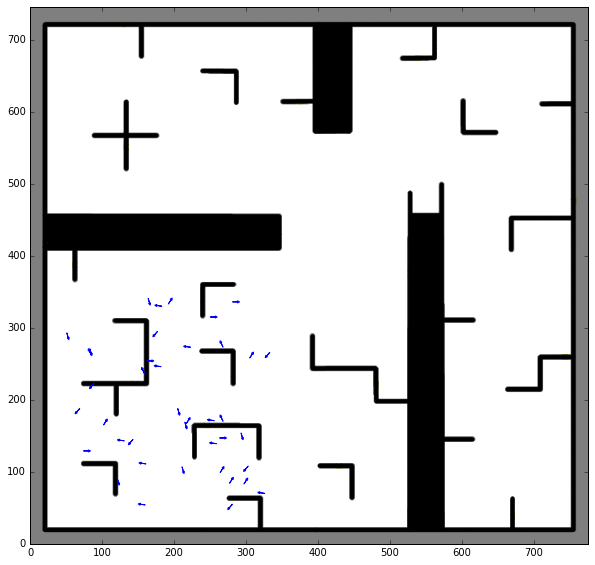

In [47]:
particulas,pos_particles = fun.randow_particle(n_part,minx, miny, maxx, maxy)

inspercles.nb_draw_map(color_image,particulas)

A função *nb_initialize_particle_cloud()* pertence ao módulo <code>inspercles</code> e já faz uma primeira aleatorização das partículas

In [48]:
# Inicializa as particulas
#particulas = inspercles.nb_initialize_particle_cloud()

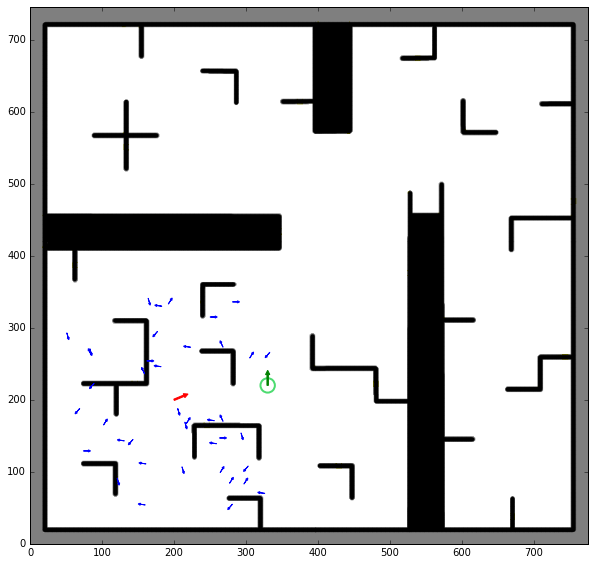

In [49]:
inspercles.nb_draw_map(color_image, particles = particulas, initial_position = initial_pose, pose=pose, robot=True)

In [50]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use *nb_simulate_lidar* passando a posição real do robô, os ângulos do sensor e a np_image com o mapa

In [51]:
leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)


In [52]:
leituras

{0.0: 187.0,
 0.89759790102565518: 57.0087712549569,
 1.7951958020513104: 313.90444405901616,
 2.6927937030769655: 59.033888572581766,
 3.5903916041026207: 218.27734651126764,
 4.4879895051282759: 198.17668884104407,
 5.3855874061539311: 74.02702209328699,
 6.2831853071795862: 187.0}

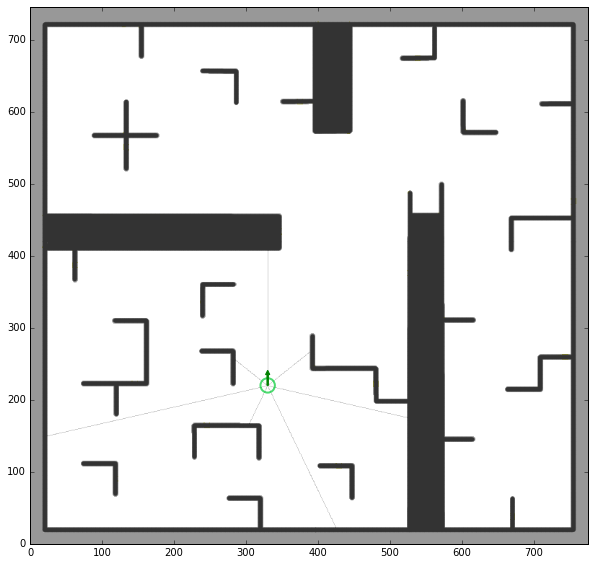

In [53]:
ax = inspercles.nb_draw_map(lidar_map, robot=True, pose=pose)
ax.imshow(color_image, alpha=0.8)
#nb_draw_map(occupancy_image)

As leituras serao retornadas pela simulacao do lidar. Sao armazenadas na forma de um dicionario com angulo: valor da leitura

In [54]:
# As predicoes teoricas das leituras
leituras

{0.0: 187.0,
 0.89759790102565518: 57.0087712549569,
 1.7951958020513104: 313.90444405901616,
 2.6927937030769655: 59.033888572581766,
 3.5903916041026207: 218.27734651126764,
 4.4879895051282759: 198.17668884104407,
 5.3855874061539311: 74.02702209328699,
 6.2831853071795862: 187.0}

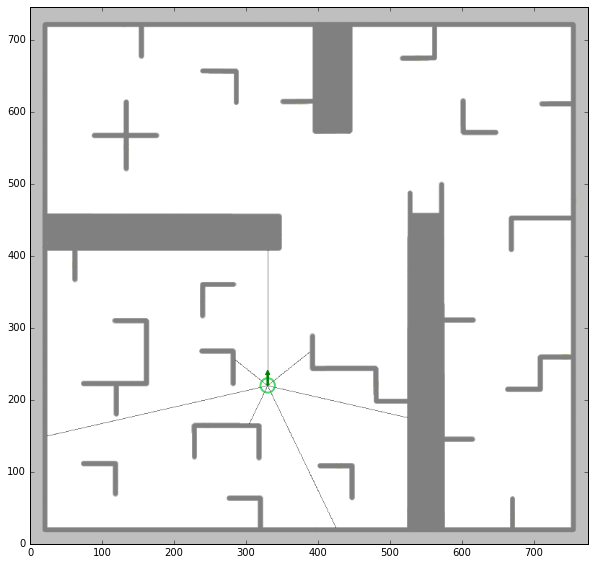

In [55]:
ax = inspercles.nb_draw_map(lidar_map, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(pil_image, alpha=0.5)

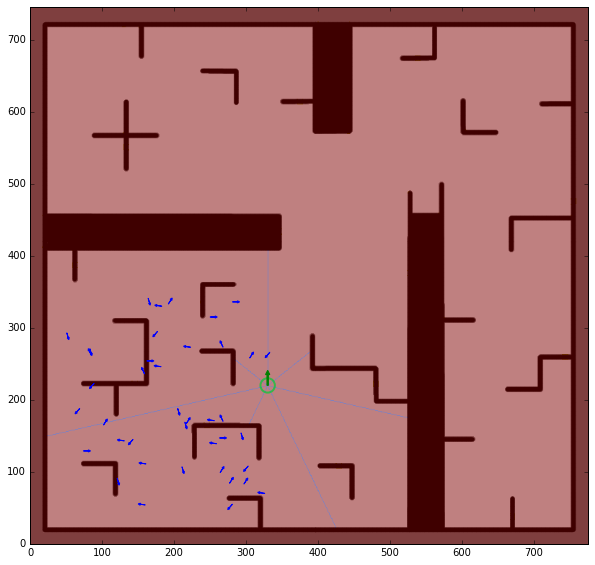

In [56]:
ax = inspercles.nb_draw_map(pil_image, pose=pose, robot=True, particles=particulas)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

## Gerando uma animação

In [57]:
# Coloque nesta lista os deslocamentos do robo

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]]

In [58]:

plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

frames = 1

count = 0
lista_p = []
valor = None

for delta in movimentos:
    for i in range(len(pose)):
        pose[i]+=delta[i]
            
    # Simula a leitura do lidar
    leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)

    # Desenha as particulas
    paticulas = fun.desvio_pd(pos_particles,delta)
    
    #for
    for j in particulas:
        #valor = inspercles.nb_find_discrete_line_versor(j.x, j.y, j.theta)
        valor, mapa_null =  inspercles.nb_simulate_lidar_fast([j.x, j.y, j.theta], angles, np_image, output_image=False)
        result = fun.calculo_Pdh(valor,leituras)
        print(result)
        lista_p.append(result)
    
    ax = inspercles.nb_draw_map(color_image, pose=pose, robot=True, particles=paticulas)
    #ax.imshow(occupancy_image, alph.2)
    # Desenha o mapa do lidar
    ax.imshow(lidar_map, alpha=0.5)
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()



4.98835386606e-25
3.02376183431e-58
1.38386575935e-36
4.35238101617e-48
3.53716587445e-72
1.25574850207e-55
8.62243585209e-68
0.0589098906546
2.34309966698e-42
2.11834219604e-45
7.13413309823e-130
8.09581612244e-45
1.37694770509e-58
6.44360089751e-22
1.00523699073e-17
1.33526339554e-46
7.04653772227e+12
9.12212387462e-13
3.22081394195e-66
2.734067343e-68
5.36748870743e-33
1.27401742126e-37
2.64282456394e-28
3.72611690393e-114
6.04393439148e-71
1.03344274396e-50
1.28776728545e-28
4.50874709908e-87
1.81160346395e-93
2.26780178423e+17
2.35823272142e-58
2.09752443419e-91
1.32985329232e-41
1.9009497083e-134
1.54703356408e+47
2.31852793732e-18
2.46400622038e-40
1.43599573294e-17
1.44159299387e-136
2.80950416725e-49
3.86124097345e-25
2.34054628082e-58
1.07118286217e-36
3.36896546696e-48
2.73794726097e-72
9.72013553718e-56
6.67420626063e-68
0.0455992677435
1.81367895742e-42
1.63970518186e-45
5.52218382429e-130
6.26657566101e-45
1.06582793442e-58
4.98767659033e-22
7.78104833954e-18
1.0335621472

In [59]:
print(max(lista_p))


2.98034555695e+187


In [60]:
print(lista_p)

[4.9883538660550402e-25, 3.0237618343057273e-58, 1.3838657593491901e-36, 4.3523810161720597e-48, 3.53716587444702e-72, 1.2557485020700141e-55, 8.6224358520853864e-68, 0.058909890654637698, 2.3430996669830212e-42, 2.1183421960397239e-45, 7.1341330982338926e-130, 8.0958161224441945e-45, 1.3769477050897972e-58, 6.443600897505458e-22, 1.0052369907340105e-17, 1.3352633955401656e-46, 7046537722267.9502, 9.1221238746166673e-13, 3.2208139419463549e-66, 2.7340673430016108e-68, 5.367488707425485e-33, 1.2740174212567294e-37, 2.6428245639445051e-28, 3.7261169039339771e-114, 6.0439343914824209e-71, 1.0334427439640092e-50, 1.2877672854500602e-28, 4.5087470990849804e-87, 1.8116034639453508e-93, 2.2678017842293078e+17, 2.3582327214225075e-58, 2.0975244341877865e-91, 1.3298532923166892e-41, 1.9009497082970547e-134, 1.5470335640813839e+47, 2.318527937323934e-18, 2.4640062203790909e-40, 1.435995732937234e-17, 1.4415929938719465e-136, 2.8095041672472004e-49, 3.861240973453144e-25, 2.3405462808151376e-58, 

In [61]:
lista_p_normed = fun.normaliza(lista_p)
print("Soma",sum(lista_p_normed))
print("Maximo",max(lista_p_normed))

('Soma', 1.0)
('Maximo', 1.0)


In [64]:
print(lista_p_normed)

[1.6737501644501325e-212, 1.0145675313587313e-245, 4.6433063982274784e-224, 1.4603612007439011e-235, 1.1868307908807392e-259, 4.2134325636963602e-243, 2.8930993696326911e-255, 1.9766127628174012e-189, 7.8618389116755797e-230, 7.1077066587240822e-233, 2.3937268092780683e-317, 2.7164018291699705e-232, 4.62009414271143e-246, 2.1620314739980365e-209, 3.372887376738966e-205, 4.4802301277736486e-234, 2.364335808593558e-175, 3.0607604723416912e-200, 1.0806847328293591e-253, 9.1736588619075946e-256, 1.80096186998104e-220, 4.274730553602743e-225, 8.8675105401316743e-216, 1.2502298249446403e-301, 2.0279307469559331e-258, 3.4675265811234078e-238, 4.3208656877025109e-216, 1.5128269567863649e-274, 6.0785013996910064e-281, 7.6091907495245588e-171, 7.912615085613605e-246, 7.0378564972103413e-279, 4.4620775239224971e-229, 6.3734468313520804e-322, 5.1907858821147245e-141, 7.7793930033418027e-206, 8.2675185588370368e-228, 4.8182189128738614e-205, 4.9406564584124654e-324, 9.4267732166165643e-237, 1.29556

Para gerar os gifs é preciso ter o pacote *imagemagick*

O imagemagick pode ser obtido com o seguinte comando:
    sudo apt-get install imagemagick 
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.fig*, que leremos abaixo:
    

In [62]:
!convert -delay 10 -loop 1 anim*png animated.gif

Infelizmente o IPython Notebook 2 nao parece exibir animacoes em Gif por default, mas voce pode abrir o arquivo no diretorio de trabalho e devera'  ve-lo.

<img src="animated.gif">

In [63]:
#for robot_v in particulas:
#    nb_simulate_lidar(robot_, angles, img)

# ![](anim.gif)